<a href="https://colab.research.google.com/github/integer-class/machine-learning/blob/main/AL_AZHAR_RRF/midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# Import Library
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [104]:
# Download kaggle
!pip install q kaggle

In [105]:
# Download Dataset
from google.colab import files
import kagglehub

files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
dataset = "atulanandjha/lfwpeople"
!kaggle datasets download -d {dataset}

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
lfwpeople.zip: Skipping, found more recently modified local copy (use --force to force download)


In [106]:
# unzip
import zipfile

with zipfile.ZipFile("lfwpeople.zip", 'r') as zip_ref:
    zip_ref.extractall("lfwpeople")


In [107]:
# Load Dataset

# Set minimum samples per class to filter out classes with too few examples
MIN_SAMPLES_PER_CLASS = 20

data_path = "/content/lfwpeople/lfw_funneled"
labels = []
images = []

# Count samples per class
class_counts = {}
for person_name in os.listdir(data_path):
    person_path = os.path.join(data_path, person_name)
    if os.path.isdir(person_path):
        n_samples = len(os.listdir(person_path))
        class_counts[person_name] = n_samples

# Filter classes with sufficient samples
valid_classes = {cls: count for cls, count in class_counts.items()
                if count >= MIN_SAMPLES_PER_CLASS}

# Load the images and labels only for valid classes
for person_name in valid_classes.keys():
    person_path = os.path.join(data_path, person_name)
    if os.path.isdir(person_path):
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            # Load image in RGB
            image = cv2.imread(image_path)
            if image is not None:
                # Convert BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Resize images to a fixed size
                image = cv2.resize(image, (64, 64))
                images.append(image)
                labels.append(person_name)

print(f"Number of valid classes: {len(valid_classes)}")
print(f"Total number of images: {len(images)}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Flatten the images
images = images.reshape(images.shape[0], -1)

Number of valid classes: 62
Total number of images: 3023


In [108]:
# Preprocess Data

# Normalize and standardize the pixel values
scaler = StandardScaler()
images = scaler.fit_transform(images)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

In [109]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels_onehot,
    test_size=0.2,
    random_state=42,
    stratify=labels_encoded  # Ensure balanced split
)

In [110]:
# Step 5: Build ANN Model
model = Sequential([
    Dense(256, activation='relu', input_shape=(images.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(labels_onehot.shape[1], activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [111]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.0229 - loss: 6.4332 - val_accuracy: 0.1240 - val_loss: 3.9250 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.1091 - loss: 4.2102 - val_accuracy: 0.1950 - val_loss: 3.7427 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1618 - loss: 3.9268 - val_accuracy: 0.2099 - val_loss: 3.5971 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1836 - loss: 3.8637 - val_accuracy: 0.2215 - val_loss: 3.5293 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1923 - loss: 3.6607 - val_accuracy: 0.2463 - val_loss: 3.4275 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.2157 - loss: 3.5180 - val_accuracy: 0.2496 - val_loss: 3.3339 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.2310 - loss: 3.3731 -

In [112]:
# Evaluate the Model

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5670 - loss: 1.8495
Test Loss: 1.9348896741867065
Test Accuracy: 0.542148768901825


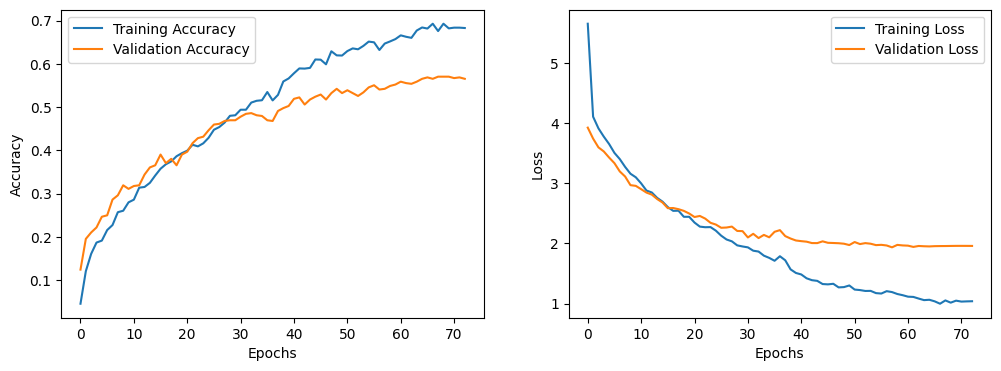

In [113]:
# Visualize the Training and Validation Accuracy and Loss

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()